# Cas d'usage n°2

Après récupération d'un jeu de données quelconque (ici les 
marchés publics conclus recensés sur la plateforme des achats de l’Etat) 
retrouver les codes communes des attributaires connaissant les libellés 
communaux et les codes postaux.


In [1]:
import io
import numpy as np
import os
import pandas as pd
from requests_cache import CachedSession

from french_cities import find_city

## Récupération des marchés publics conclus

In [2]:
url = (
    "https://static.data.gouv.fr/"
    "resources/"
    "marches-publics-conclus-recenses-sur-la-plateforme-des-achats-de-letat/"
    "20160701-120733/Export_ETALAB_2015_complete.xlsx"
)
s = CachedSession()
r = s.get(url)
obj = io.BytesIO(r.content)
obj.seek(0)
df = pd.read_excel(obj)
for c in df.columns:
    try:
        df[c] = df[c].str.replace("^ *$", "", regex=True).replace("", None)
    except AttributeError:
        pass
df = df.dropna(how="all", axis=1)
df.head()

,Année de notification,Entité Publique,Entite d'achat,Nom Attributaire,SIRET Attributaire,Date de notification,Code Postal Attributaire,Ville,Nature du Marché,Objet du marché,Tranche budgetaire,Montant
0,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,SEDONA,42053121200033,2015-04-30,75009,PARIS 9,Services,Prestations d'assistance à la maitrise d'ouvra...,"50 000 HT à 89 999,99 HT","63 070,00"
1,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,ATOS CONSULTING,41033322300049,2015-01-21,75009,PARIS 9,Services,Etude à caractère prospectif des méthodes et o...,"90 000 HT à 124 999,99 HT","111 576,94"
2,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-029 - DGFI...,R.T.B. 56 ENTREPRISE GENERALE,52845802900014,2015-03-25,56850,CAUDAN,Travaux,Réorganisation de l'accueil et la mise aux nor...,"4 000 HT à 19 999,99 HT","19 346,95"
3,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 1 ...,"0 à 3 999,99 HT","2 000,00"
4,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 2 ...,"20 000 HT à 49 999,99 HT","37 000,00"


## Retraitement des codes postaux manifestement erronés

In [3]:
ix = df[
    ~df["Code Postal Attributaire"].fillna("").str.fullmatch("[0-9]{5}")
].index
df.loc[ix, "Code Postal Attributaire"] = np.nan

## Configuration de l'API INSEE

In [4]:
os.environ["insee_key"] = "********************"
os.environ["insee_secret"] = "********************"

## Reconnaissance des codes communes avec french-cities

In [5]:
df = find_city(
    df,
    year="last",
    x=False,
    y=False,
    epsg=False,
    city="Ville",
    dep=False,
    address=False,
    postcode="Code Postal Attributaire",
    use_nominatim_backend=True,
    field_output="codeInsee",
)
df.head()

,Année de notification,Entité Publique,Entite d'achat,Nom Attributaire,SIRET Attributaire,Date de notification,Code Postal Attributaire,Ville,Nature du Marché,Objet du marché,Tranche budgetaire,Montant,codeInsee
index,,,,,,,,,,,,,
0,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,SEDONA,42053121200033,2015-04-30,75009,PARIS 9,Services,Prestations d'assistance à la maitrise d'ouvra...,"50 000 HT à 89 999,99 HT","63 070,00",75056
1,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,ATOS CONSULTING,41033322300049,2015-01-21,75009,PARIS 9,Services,Etude à caractère prospectif des méthodes et o...,"90 000 HT à 124 999,99 HT","111 576,94",75056
2,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-029 - DGFI...,R.T.B. 56 ENTREPRISE GENERALE,52845802900014,2015-03-25,56850,CAUDAN,Travaux,Réorganisation de l'accueil et la mise aux nor...,"4 000 HT à 19 999,99 HT","19 346,95",56036
3,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 1 ...,"0 à 3 999,99 HT","2 000,00",53013
4,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 2 ...,"20 000 HT à 49 999,99 HT","37 000,00",53013


In [6]:
df.codeInsee.isnull().value_counts().to_frame("est vide")

,est vide
codeInsee,
False,11267
True,567


<Axes: xlabel='codeInsee'>

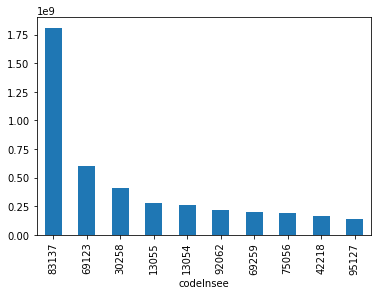

In [7]:
df["Montant"] = pd.to_numeric(df["Montant"].str.replace(",", ".").str.replace(" ", ""))
df.groupby("codeInsee")["Montant"].sum().sort_values(ascending=False).head(10).plot(kind="bar")